# MIBI-TOF Example with SquidPy and Napari

In [3]:
import ark
import spatialdata as sd
from napari_spatialdata import Interactive
import spatialdata_plot
import squidpy as sq
import scanpy as sc
from pathlib import Path

/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62648 instead
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'shuffle' has been deprecated; please use 'dataframe.shuffle.algorithm' instead
  warnings.warn(


In [4]:
!mkdir ../../../data/mibitof_example_data/
!mkdir ../../../data/mibitof_example_data/mibitof_data
!wget -P ../../../data/mibitof_example_data/mibitof_data https://s3.embl.de/spatialdata/spatialdata-sandbox/mibitof.zip
!tar -xzf ../../../data/mibitof_example_data/mibitof_data/mibitof.zip -C ../../../data/mibitof_example_data/mibitof_data/.

mkdir: ../../../data/mibitof_example_data/: File exists
mkdir: ../../../data/mibitof_example_data/mibitof_data: File exists
--2023-10-04 23:58:53--  https://s3.embl.de/spatialdata/spatialdata-sandbox/mibitof.zip
Resolving s3.embl.de (s3.embl.de)... 194.94.45.80
Connecting to s3.embl.de (s3.embl.de)|194.94.45.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8109254 (7.7M) [application/zip]
Saving to: ‘../../../data/mibitof_example_data/mibitof_data/mibitof.zip.8’

mibitof.zip.8       100%[===================>]   7.73M  5.19MB/s    in 1.5s    

2023-10-04 23:58:56 (5.19 MB/s) - ‘../../../data/mibitof_example_data/mibitof_data/mibitof.zip.8’ saved [8109254/8109254]



In [5]:
sdata = sd.read_zarr("../../../data/mibitof_example_data/mibitof_data/data.zarr")
sdata

SpatialData object with:
├── Images
│     ├── 'point8_image': SpatialImage[cyx] (3, 1024, 1024)
│     ├── 'point16_image': SpatialImage[cyx] (3, 1024, 1024)
│     └── 'point23_image': SpatialImage[cyx] (3, 1024, 1024)
├── Labels
│     ├── 'point8_labels': SpatialImage[yx] (1024, 1024)
│     ├── 'point16_labels': SpatialImage[yx] (1024, 1024)
│     └── 'point23_labels': SpatialImage[yx] (1024, 1024)
└── Table
      └── AnnData object with n_obs × n_vars = 3309 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'batch', 'library_id'
    uns: 'spatialdata_attrs'
    obsm: 'X_scanorama', 'X_umap', 'spatial': AnnData (3309, 36)
with coordinate systems:
▸ 'point8', with elements:
        point8_image (Images), point8_labels (Labels)
▸ 'point16', with elements:
        point16_image (Images), point16_labels (Labels)
▸ 'point23', with elements:
        point23_image (Images), point23_labels (Labels)

In [6]:
sdata.table.uns

{'spatialdata_attrs': {'instance_key': 'cell_id',
  'region': ['point8_labels', 'point16_labels', 'point23_labels'],
  'region_key': 'library_id'}}

In [7]:
sdata.table.uns["spatialdata_attrs"]["instance_key"] = "instance_id"
sdata.table.uns["spatialdata_attrs"]["region_key"] = "region"
sdata.table.obs.rename(columns={"library_id": "region", "cell_id": "instance_id"}, inplace=True)
sdata.table.obs

,row_num,point,instance_id,X1,center_rowcoord,center_colcoord,cell_size,category,donor,Cluster,batch,region
9376-1,9479,8,2,65222.0,37.0,6.0,474.0,carcinoma,90de,Epithelial,1,point8_labels
9377-1,9480,8,4,65224.0,314.0,3.0,126.0,carcinoma,90de,Epithelial,1,point8_labels
9378-1,9481,8,5,65225.0,407.0,6.0,398.0,carcinoma,90de,Epithelial,1,point8_labels
9379-1,9482,8,6,65226.0,439.0,20.0,1749.0,carcinoma,90de,Epithelial,1,point8_labels
9380-1,9483,8,7,65227.0,479.0,6.0,407.0,carcinoma,90de,Imm_other,1,point8_labels
...,...,...,...,...,...,...,...,...,...,...,...,...
4270-0,4322,23,1479,61793.0,519.0,1018.0,125.0,carcinoma,21d7,Tcell_CD4,0,point23_labels
4271-0,4323,23,1480,61794.0,929.0,1018.0,190.0,carcinoma,21d7,Imm_other,0,point23_labels
4272-0,4324,23,1481,61795.0,999.0,1019.0,173.0,carcinoma,21d7,Imm_other,0,point23_labels
4273-0,4325,23,1482,61796.0,322.0,1018.0,181.0,carcinoma,21d7,Myeloid_CD11c,0,point23_labels


## Co-occurrence across spatial dimensions

We can visualize cluster co-occurrence in spatial dimensions using the original spatial coordinates. The co-occurrence score is defined as:

$$\frac{p(A|B)}{p(A)} $$

where $p(A|B)$ is the conditional probability of observing a cluster $exp$ conditioned on the presence of a cluster $cond$, whereas $p(A)$ is the probability of observing in the radius size of interest. The score is computed across increasing radii size around each cell in the tissue.

"co-occurrence" aka conditional probability can be extended to multiple clusters as well.



/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):


  0%|          | 0/1 [00:00<?, ?/s]

ERROR: Unable to fetch palette, reason: 'Cluster_colors'. Using `None`.


/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/seabor

  0%|          | 0/1 [00:00<?, ?/s]

ERROR: Unable to fetch palette, reason: 'Cluster_colors'. Using `None`.


/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/seabor

  0%|          | 0/1 [00:00<?, ?/s]

ERROR: Unable to fetch palette, reason: 'Cluster_colors'. Using `None`.


/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/seabor

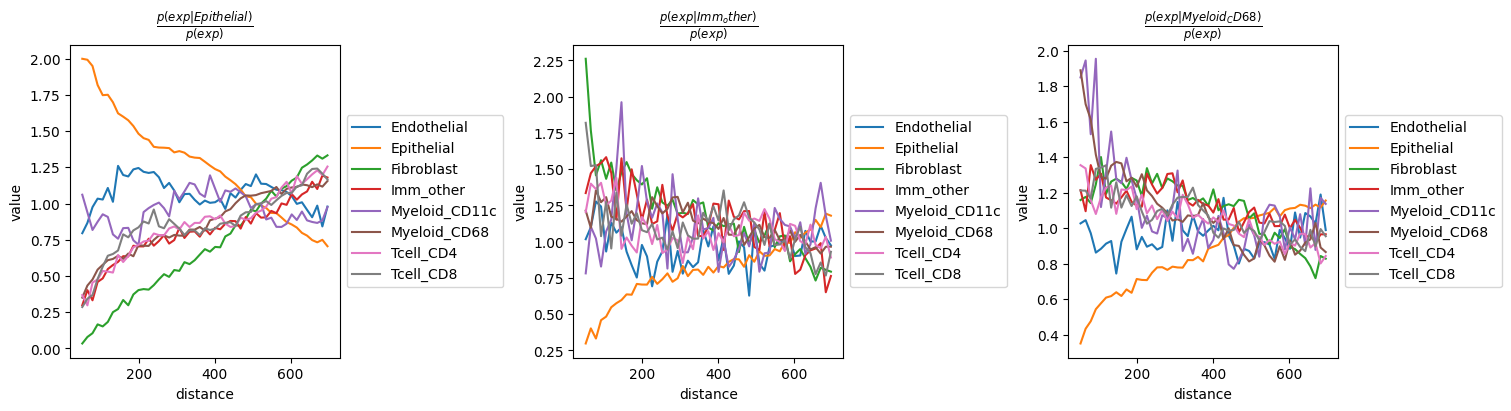

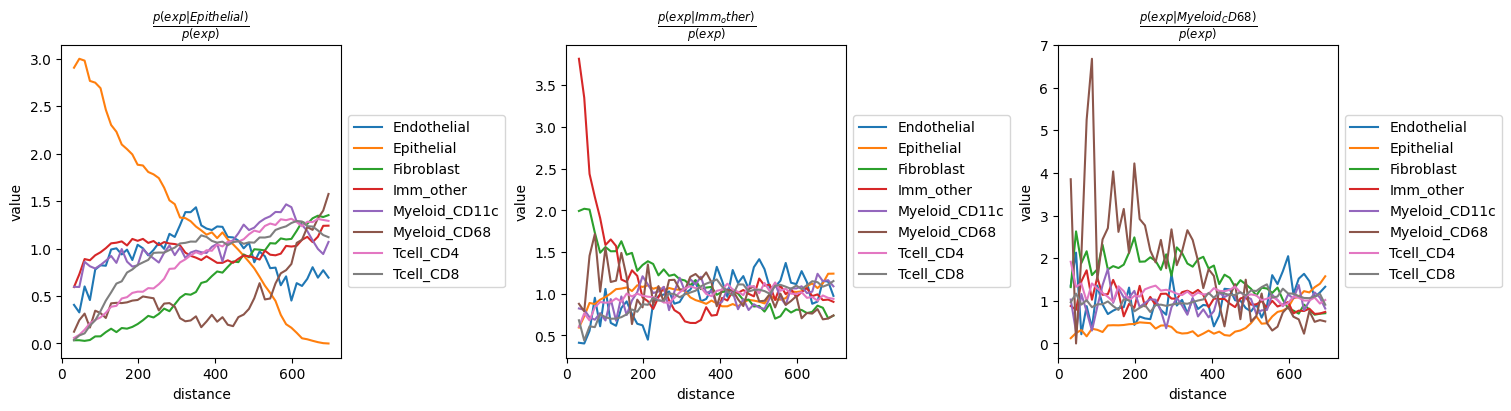

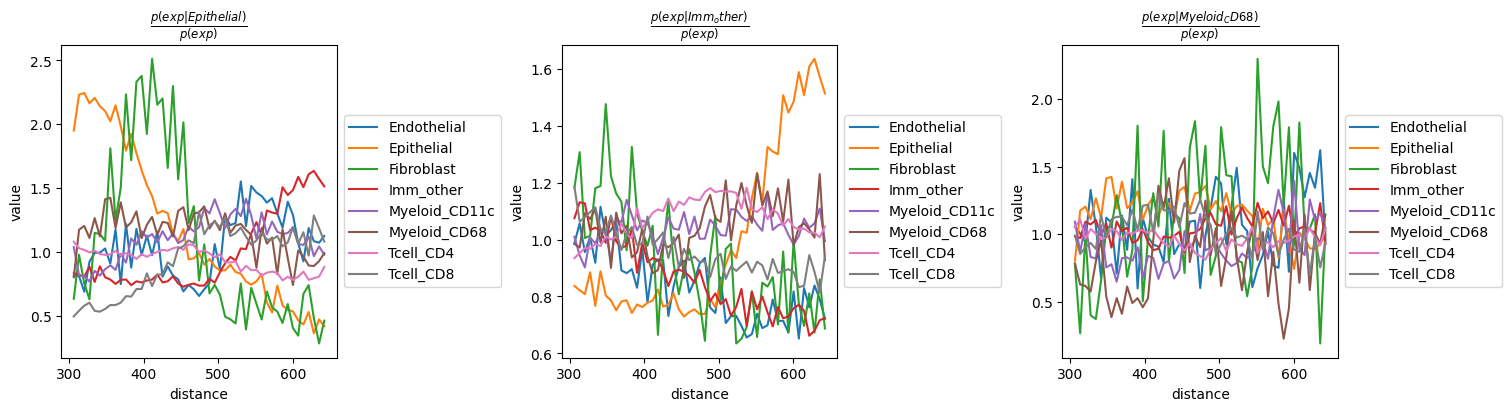

In [8]:
for fov_id, fov_sd in sdata.iter_coords:
    sq.gr.co_occurrence(fov_sd, cluster_key="Cluster")
    
    sq.pl.co_occurrence(
        fov_sd.table,
        cluster_key="Cluster",
        clusters=["Epithelial", "Imm_other", "Myeloid_CD68"],
        figsize=(15, 4),
    )

In [10]:
sds = []

for fov_id, fov_sd in sdata.iter_coords:
    sq.gr.spatial_neighbors(fov_sd, library_key="region",)
    sc.pp.pca(fov_sd.table)
    sc.pp.neighbors(fov_sd.table)
    sc.tl.leiden(fov_sd.table)
    sq.gr.nhood_enrichment(fov_sd, cluster_key="leiden")
    sq.gr.nhood_enrichment(fov_sd, cluster_key="Cluster")
    sq.gr.centrality_scores(fov_sd, cluster_key="Cluster", score = None)
    sds.append(fov_sd)

/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/squidp

  0%|          | 0/1000 [00:00<?, ?/s]

  0%|          | 0/1000 [00:00<?, ?/s]

/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/squidp

  0%|          | 0/1000 [00:00<?, ?/s]

/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):


  0%|          | 0/1000 [00:00<?, ?/s]

/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/squidp

  0%|          | 0/1000 [00:00<?, ?/s]

/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/squidpy/gr/_utils.py:141: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[key]):


  0%|          | 0/1000 [00:00<?, ?/s]

In [11]:
sdata2 = sd.concatenate(sds)

/opt/homebrew/Caskroom/mambaforge/base/envs/ark-spatial-dev/lib/python3.11/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):


In [12]:
sdata2

SpatialData object with:
├── Images
│     ├── 'point8_image': SpatialImage[cyx] (3, 1024, 1024)
│     ├── 'point16_image': SpatialImage[cyx] (3, 1024, 1024)
│     └── 'point23_image': SpatialImage[cyx] (3, 1024, 1024)
├── Labels
│     ├── 'point8_labels': SpatialImage[yx] (1024, 1024)
│     ├── 'point16_labels': SpatialImage[yx] (1024, 1024)
│     └── 'point23_labels': SpatialImage[yx] (1024, 1024)
└── Table
      └── AnnData object with n_obs × n_vars = 3309 × 36
    obs: 'row_num', 'point', 'instance_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'batch', 'region', 'leiden'
    uns: 'spatialdata_attrs'
    obsm: 'X_scanorama', 'X_umap', 'spatial', 'X_pca': AnnData (3309, 36)
with coordinate systems:
▸ 'point8', with elements:
        point8_image (Images), point8_labels (Labels)
▸ 'point16', with elements:
        point16_image (Images), point16_labels (Labels)
▸ 'point23', with elements:
        point23_image (Images), point23_labels (L

In [13]:
sds[0].table

AnnData object with n_obs × n_vars = 1045 × 36
    obs: 'row_num', 'point', 'instance_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'batch', 'region', 'leiden'
    uns: 'spatialdata_attrs', 'spatial_neighbors', 'pca', 'neighbors', 'leiden', 'leiden_nhood_enrichment', 'Cluster_nhood_enrichment', 'Cluster_centrality_scores'
    obsm: 'X_scanorama', 'X_umap', 'spatial', 'X_pca'
    varm: 'PCs'
    obsp: 'spatial_connectivities', 'spatial_distances', 'distances', 'connectivities'

In [14]:
Interactive(sds)

In [ ]:
sq.pl.nhood_enrichment(sds[0].table, cluster_key="leiden", figsize=(5, 5))

In [ ]:
sq.pl.nhood_enrichment(sds[0].table, cluster_key="Cluster", figsize=(5, 5))